# Rank-1 Introduction

# Import packages

### Import python packages

In [1]:
import re, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
import random
from tqdm import trange,tqdm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

### Import custom packages

In [2]:
from generate import generate
from plot_training import plot_training

# Generate the Dataset

### Set parameters

In [3]:
n1 = 10    #n1 etats uniques
n2 = 100    #n2 nuisances uniques
nx = 100  # nombre de etats (pas uniques) dans la matrice X
nt = 10  # n_tau, c'est le nombre de blocs pris d'une colonne de D
p = 10   # dimension de l'espace latent coherent
q = 10  # dimension de l'espace latent nuisant
dropout_rate = 0.5  # le dropout pour l'encodeur nuisant
states = np.exp(np.arange(n1)/4)   # liste des n1 etats (ex. (1,2))
nuisances = np.exp(np.arange(n2)/n2/4) # liste des n2 nuisances (ex. (1,2))
lam=5000

In [4]:
path='./p=%d,q=%d,lam=%d'%(p,q,lam)

### Generate X

In [5]:
data = generate(states,nuisances,nx,nt,replace=0)
X = data.X
X_states = data.X_states
X_nuisances = data.X_nuisances

### What blocks in D is selected by X?

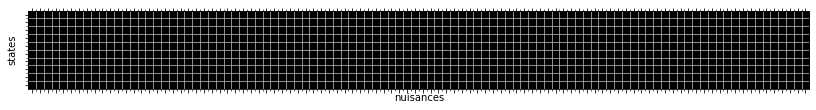

In [6]:
waiting_samples = data.waiting_samples

D_selected = np.ones((n1,n2))
for i in range(n1):
    for j in range(n2):
        D_selected[i][waiting_samples[i]] = 0    

plt.figure(figsize=(14, 2))
plt.matshow(data.selected_times, fignum=1, cmap=plt.get_cmap('binary_r'))
plt.xlabel('nuisances')
plt.ylabel('states')
plt.xticks(range(n2))
plt.yticks(range(n1))
plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], labels=['']*(n2-1), minor=True)
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], labels=['']*(n1-1), minor=True)
plt.grid(which='minor')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
#plt.title('How many times has each block in D been selected')
#plt.colorbar(location='bottom')
plt.show()

# Set SymAE

### Set layers

In [7]:

'''
class SymmetricEncoderDense0D(tf.keras.Model):
    
    def __init__(self, p, nt):
        super(SymmetricEncoderDense0D, self).__init__(name='sym_encoder')
        self.nt_out = p
        self.nt_in = nt
        self.d1 = tfkl.Dense(p)
        
    def call(self, x, training=False):
        x = tf.math.reduce_mean(x,axis=1)
        x = self.d1(x)
        return x
'''

class SymmetricEncoderDense0D(tf.keras.Model):
    
    def __init__(self, p, nt):
        super(SymmetricEncoderDense0D, self).__init__(name='')
        
        # CEnc(X_i) = w5*w4*Relu(w3*sum_t w2*Relu(w1*X_i[t]))
        # where wk is the weight matrix of self.dk, for k in [5]
        
        self.nt_out = p
        self.nt_in = nt
        self.d1 = tfkltd(tfkl.Dense(100, activation = tf.keras.layers.ReLU()))
        self.d2 = tfkltd(tfkl.Dense(1000, activation = None))
        self.d3 = tfkl.Dense(100, activation = tf.keras.layers.ReLU())
        self.d4 = tfkl.Dense(10, activation = None)
        self.d5 = tfkl.Dense(p)
        
    def call(self, x, training=False):
        # input: x, ligne de taille nt de la matrice X.
        
        x = self.d1(x)
        x = self.d2(x)
        x = tf.math.reduce_mean(x, axis=1)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        return x

    
# 你是在让 nuisance encoder 记住states
class NuisanceEncoderDense0D(tf.keras.Model):
    def __init__(self, q, nt):
        super(NuisanceEncoderDense0D, self).__init__(name='nui_encoder')
        self.d1 = tfkl.Dense(1000, activation=tf.keras.layers.LeakyReLU())
        self.d2 = tfkl.Dense(q)
        
    def call(self, x, training=False):
        x=self.d1(x)
        x=self.d2(x)
        return x
    
class DistributeZsym(tf.keras.Model):
    def __init__(self, ntau, nz0, nzi):
        super(DistributeZsym, self).__init__(name='dist')
        self.nz0=nz0
        self.nzi=nzi
        self.ntau=ntau
        self.ri=tfkl.Reshape(target_shape=(ntau,nzi))
        self.repeat=tfkl.RepeatVector(ntau)
        
    def call(self, z, training=False):
        z0,zi=tf.split(z,[self.nz0, self.ntau*self.nzi],axis=1)
        zi=self.ri(zi)
        z0=self.repeat(z0)
        out=tfkl.concatenate([z0, zi],axis=2)
        return out
    
'''
class MixerDense0D(tf.keras.Model):
    def __init__(self, n_out=1, n_in=p+q):
        super(MixerDense0D, self).__init__(name='mixer')
        #self.d1=tfkl.Dense(2)
        
    def call(self, x, training=False):
        #x=self.d1(x)
        x=tf.math.reduce_sum(x, axis=-1, keepdims=True)
        return x
'''

class MixerDense0D(tf.keras.Model):
    # C'est le petit dec je pense. Qui va de Rp+q a R, donc dec(C_i, N_i[t])
    
    def __init__(self, n_out = 1, n_in = p+q):
        
        # ok. c'est le decodeur en qq sorte. On va "mixer" (i.e., concatener)
        # l'encodeur coherent à l'encodeur nuisant
        
        super(MixerDense0D, self).__init__(name='')
        self.d1 = tfkl.Dense(1000, activation = tf.keras.layers.ReLU())
        #self.d1 = tfkl.Dense(4*(n_in), activation = tf.keras.layers.ReLU(), use_bias = False)
        #self.d2 = tfkl.Dense(n_in, activation = tf.keras.layers.ReLU(), use_bias = False)
        #self.d3 = tfkl.Dense(5000, activation = tf.keras.layers.ReLU())
        self.d4 = tfkl.Dense(100, activation = tf.keras.layers.ReLU())
        #self.d5 = tfkl.Dense(1, activation = tf.keras.layers.ReLU(), use_bias = False)
        self.d6 = tfkl.Dense(1, activation=None)
        
    def call(self, z, training = False):
        # z c'est la var latente. donc de dim p+q en principe.
        x = self.d1(z)
        #x = self.d2(x)
        #x = self.d3(x)
        x = self.d4(x)
        #x = self.d5(x)
        x = self.d6(x)
        return x

In [8]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=1.0):
        super(LatentCat, self).__init__(name='latentcat')
        self.drop = tfkl.Dropout(alpha)
        
    def call(self, zsym, znuisance, training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

### model

In [9]:
class SymAE(tf.keras.Model):
    
    def __init__(self, N, nt, p, q, dropout_rate): 
        super(SymAE, self).__init__()
        
        # Build symmetric encoder
        sym_encoder = SymmetricEncoderDense0D(p,nt)
        self.sym_encoder=sym_encoder
        
        # Build nuisance encoder
        nui_encoder = NuisanceEncoderDense0D(q,nt)
        self.nui_encoder = nui_encoder
        
        #Build latentcat
        latentcat = LatentCat(alpha=dropout_rate)
        self.latentcat = latentcat
        
        # Build distribute in decoder
        distzsym = DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = MixerDense0D(1,p+q)
        self.mixer = mixer
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output=latentcat(zsym,znuisance)
        encoder=tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output=mixer(distzsym(decoder_input))
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, input_tensor, training=False):
        return self.decoder(self.encoder(input_tensor))

### Initialize SymAE

In [10]:
model = SymAE(nx, nt, p, q, 0.5)
clear_output()
try:
    model.load_weights(path+'/checkpoint')
    print("weight exists")
except:
    print("weight doesn't exist")

weight exists


In [11]:
model.latentcat.drop.rate = 0.5

### Select optimizer

In [12]:
Adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=Adam)
clear_output()

In [13]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [14]:
M = 10000
epochs = range(M)
losses = [np.nan]*M
redata = [np.nan]*M
sample_size = 20
redatum_list = list(zip(np.random.randint(0,nx,sample_size),np.random.randint(0,nx,sample_size)))

# Train

### From scratch

In [15]:
@tf.function
def redatum(X1, X2):
    return model.decoder(model.latentcat(model.sym_encoder(X1), model.nui_encoder(X2)))
@tf.function
def redatum_loss(X):
    s = []
    for (i1,i2) in redatum_list:
        X1 = X[i1:i1+1]
        X2 = X[i2:i2+1]
        s.append(mse(redatum(X1,X2), states[X_states[i1]]+nuisances[X_nuisances[i2,:]]))
    return sum(s)/sample_size

@tf.function
def reconstruction_loss(model, x, training=False):
    x_hat = model(x, training=True)
    return mse(x, x_hat)

def norm(x, ord=2, axis=-1):
    if ord==1:
        return tf.math.abs(x,axis=axis)
    elif ord==2:
        return tf.sqrt(tf.reduce_sum(tf.square(x), axis=axis) + 1.0e-12)
    
@tf.function
def set_distance(s1, s2):
    '''WARNING: this layer rely on broadcasting'''
    s1_ = tf.expand_dims(s1, 0)
    s1__ = tf.expand_dims(s1, 1)
    s2_ = tf.expand_dims(s2, 0)
    s2__ = tf.expand_dims(s2, 1)
    s12 = tf.reduce_mean(norm(s1_-s2__, axis=-1))
    s11 = tf.reduce_mean(norm(s1_-s1__, axis=-1))
    s22 = tf.reduce_mean(norm(s2_-s2__, axis=-1))
    s = s12-s11/2-s22/2
    return s

@tf.function
def mutual_info_penalty(model, x, training=False):
    coherent_code = model.sym_encoder(x, training=False)
    nuisance_code = model.nui_encoder(x, training=False)
    #tf.print(coherent_code.shape,nuisance_code.shape)
    all_points = tf.reshape(nuisance_code,[-1,q])
    std = tf.math.reduce_std(all_points, 0)
    s = 0.0
    for i in trange(nx):
        s += set_distance(all_points/std, all_points[i*nt:(i+1)*nt,:]/std)
    return s

@tf.function
def train_step(model, x, training=True):
    with tf.GradientTape() as tape:
        loss_rec = reconstruction_loss(model, x, training)
        loss_cor = mutual_info_penalty(model, x, training)
        loss = loss_rec + lam*loss_cor
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_rec, loss_cor

In [16]:
for epoch in range(1000):
    loss_rec, loss_cor = train_step(model, X)
    print("For epoch {:d}, reconstruction loss is {:f}, correlation loss is {:f}."
          .format(epoch, loss_rec, loss_cor))
    losses[epoch]=loss_rec
    redata[epoch]=redatum_loss(X)
    clear_output(wait=True)

For epoch 999, reconstruction loss is 0.062753, correlation loss is 79.770660.


### Plot

In [17]:
k = 0
#print(X[k])
#print('state:',states[X_states[k]])
#print('->')
#tf.print('sym:',model.sym_encoder(X[k:k+1]))
#tf.print('nui:',model.nui_encoder(X[k:k+1]))
#print('->')
#tf.print(model(X[k:k+1]))

### Loss-epoch graph

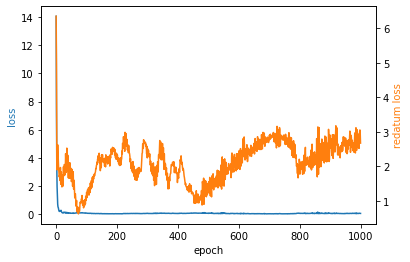

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(epochs,losses,'C0')
ax2.plot(epochs,redata,'C1')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='C0')
ax2.set_ylabel('redatum loss', color='C1')
plt.show()

### Save weights

In [19]:
import datetime
#model.save_weights('./checkpoint/'+datetime.now().strftime("%B%d"))
model.save_weights(path+'/checkpoint')
print("weights saved")

weights saved


# Visualize training loss

### Creat a dict mapping from subscripts of D to subscripts of X

This map is the inverse of X_states and X_nuisances

In [20]:
subscript_map = {}
for i in range(nx):
    for j in range(nt):
        subscript_map[(X_states[i],X_nuisances[i,j])] = (i,j)

### Plot D and SymAE(X)

4/4 [==============================] - 0s 5ms/step


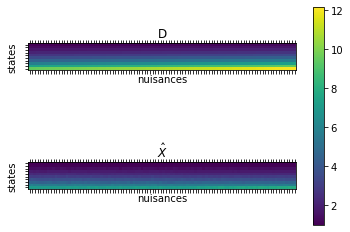

In [21]:
D = data.D
X_hat = model.predict(X)[:,:,0]
X_converted_max = np.empty((n1,n2))
X_converted_max.fill(-np.inf)
X_converted_min = np.empty((n1,n2))
X_converted_min.fill(np.inf)
for i in range(nx):
    for j in range(nt):
        i_D = X_states[i]
        j_D = X_nuisances[i,j]
        X_converted_max[i_D,j_D] = max(X_hat[i,j],X_converted_max[i_D,j_D])
        X_converted_min[i_D,j_D] = min(X_hat[i,j],X_converted_max[i_D,j_D])
        
def plot_reconstruct(D,X_converted):
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(6,4))
    norm = mcolors.Normalize(vmin=np.amin(D), vmax=np.amax(D))
    pcm = axs[0].matshow(D, norm = norm)
    axs[0].set_xlabel('nuisances')
    axs[0].set_ylabel('states')
    axs[0].set_xticks(range(n2))
    axs[0].set_yticks(range(n1))
    axs[0].set_title('D')
    pcm = axs[1].matshow(X_converted, norm = norm)
    axs[1].set_xlabel('nuisances')
    axs[1].set_ylabel('states')
    axs[1].set_xticks(range(n2))
    axs[1].set_yticks(range(n1))
    axs[1].set_title('$\hat{X}$')
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
    fig.colorbar(pcm,ax=axs, location='right')
    return fig

fig = plot_reconstruct(D, X_converted_max)
#fig.suptitle('Training loss', fontsize=15)
plt.show()
#fig = plot_reconstruct(D,X_converted_min)
#fig.suptitle('Training loss X_min',fontsize=15)
#plt.show()

# Visualize performance of redatuming

### Evaluate latent code

In [22]:
Cs = model.sym_encoder.predict(X, verbose=0)
Ns = model.nui_encoder.predict(X, verbose=0)
print(Cs.shape)
print(Ns.shape)

(100, 10)
(100, 10, 10)


### Creat a dict, mapping from coordinates of missing blocks (in D) to coordinates i, i', j (in X)

In [23]:
missing_map = {}
for i_D in range(n1):
    for j_D in range(n2):
        state_candidates = np.argwhere(X_states==i_D) 
        nuisance_candidates = np.argwhere(X_nuisances==j_D) 
        i_s, = state_candidates[np.random.choice(state_candidates.shape[0])]
        i_n, j_n = nuisance_candidates[np.random.choice(nuisance_candidates.shape[0])]
        missing_map[i_D,j_D] = (i_n,i_s,j_n)
for i_D in range(n1):
    for j_D in range(n2):
        i, i_prime, j = missing_map[i_D,j_D] 
        assert X_states[i_prime] == i_D
        assert X_nuisances[i,j] == j_D

### Define a function dec

In [24]:
def dec(latent_code):
    tem = latent_code[np.newaxis, np.newaxis, :]
    tem = np.repeat(tem, 1, axis=1)
    tem = model.mixer.predict(tem, verbose=0)
    return tem[0,0,0]

### Fill out X_redatum

Then we evaluate $\hat{X}_{i_n \to i_s}[j_n]$ and put it at X_redatum[i_D,j_D].  
In the code below, i=i_n, i_prime=i_s, j=j_n.  

In [25]:
X_redatum = np.copy(X_converted_max)
coherent_i_prime = np.empty((1,p))
nuisance_i_j = np.empty((1,q*nt))

for (i_D, j_D) in tqdm(missing_map.keys()):
    i, i_prime, j = missing_map[i_D, j_D]
    coherent_i_prime = Cs[i_prime, :]
    nuisance_i_j = Ns[i,j]
    merger = np.concatenate([coherent_i_prime,nuisance_i_j])
    X_redatum[i_D,j_D] = dec(merger)  
clear_output()

### Plot

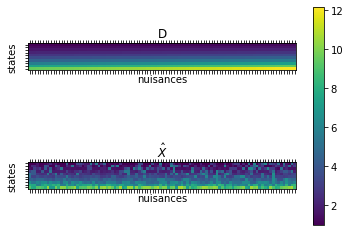

In [26]:
fig = plot_reconstruct(D, X_redatum)
#fig.suptitle('Redatuming', fontsize=12)
plt.savefig(path+'/redatum.pdf', format='pdf', bbox_inches='tight')
plt.show()